### **National-Scale Detection of Reservoir Impacts Through Hydrological Signatures: Code Workflow**

This script takes you through the steps needed to calculate the signatures introduced in Salwey et al. (2022) and plot the results.

The script will produce the input flow, precipitation and PET files from the CAMELS-GB database (Coxon et al. 2020) which can be downloaded here: https://doi.org/10.5285/8344e4f3-d2ea-44f5-8afa-86d2987543a9. The script also uses Data Set S1 published by Salwey et al. (2022) to define the two samples of gauges. 

The CAMELS-GB database only contains 131 of the 186 reservoir gauges used in the published analysis, and so whilst this code will allow you to reproduce the plots in the same style, the smaller sample of catchments means that they will not be exactly the same. The data files produced by this script only include those gauges which are included in the CAMELS-GB dataset, although the data for the remaining gauges can be downloaded from the locations described in the data availablilty statement at the end of the paper if needed. 

Data files are produced with a column for each gauge and a row for each day in the analysis window, e.g. the reservoir precipitation file assosiated with the published analysis has 186 columns (for each of the 186 reservoir gauges) and 12418 rows (one for each day in the 01/10/1980 - 30/09/2014 window). If using a new sample of gauges, the flow, precipitation and PET data must be read in to the script in the same format. 

**Section 1: Reading in Data**

The following section will define the timeframe and data sources for analysis and generate data files in the necessary format for the rest of the script. 

Locate the files needed for analysis.

In [ ]:
# Insert file path to location of signature_functions.py script (available to download from Github)
signature_scipt_location = ''
# Insert file path to downloaded CAMELS-GB data 
CAMELS_data_location = '' 
# Insert file path to Data Set S1
catchment_information_location = ''

In [ ]:
# Import the libraries used throughout the analysis 
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import statistics
import math 

In [ ]:
# Change working directory to location of signature_functions.py script (available to download from Github)
os.chdir(signature_scipt_location)

# Import script containing signature functions 
from signature_functions import *

In [2]:
# Read in Data Set S1 containing catchment descriptors and data
os.chdir(catchment_information_location)
catchment_information = pd.DataFrame(pd.read_csv('Data Set S1.csv', skiprows = 1))

# Make 2 seperate files for reservoir and benchmark catchments 
res_catchments = catchment_information[catchment_information.Sample == 'Reservoir']
benchmark_catchments = catchment_information[catchment_information.Sample == 'Benchmark']

Define the dates of analysis period.

In [ ]:
# Date must be defined in a format that pandas date range can interpret 
start = '10/01/1980'
end = '09/30/2014'

# Define dates in the same format as in the CAMELS data 
start_GB = '1980-10-01'
end_GB = '2014-09-30'

Produce flow, PET and precipitation dataframes combining timeseries for all catchments from CAMELS-GB data. 

In [3]:
dates = pd.Series(pd.date_range(start='10/01/1980', end= '09/30/2014', freq='D'))

# Locate to the timeseries folder in the CAMELS database 
os.chdir(CAMELS_data_location+'\\data\\timeseries')

# Find out which reservoir catchments are in the CAMELS dataset 
list_dir= os.listdir(CAMELS_data_location+'\\data\\timeseries')
CAMELS_gauges = []
CAMELS_gauges_index = []
res_catchment_index = []

for i in range(0, len(res_catchments)):    
    for x in range(0, len(list_dir)): 
        gauge = list_dir[x].strip('CAMELS_GB_hydromet_timeseries_')
        gauge = gauge.rstrip('19701001-20150930.csv ')
        gauge = gauge.rstrip('_')
        if gauge == str(res_catchments.iloc[i,1]):
            CAMELS_gauges.append(gauge)
            CAMELS_gauges_index.append(x)
            res_catchment_index.append(i)
            
# Find out which benchmark catchments are in the CAMELS dataset 
benchmark_gauges = []
benchmark_gauges_index = []
            
for i in range(0, len(benchmark_catchments)):
    for x in range(0, len(list_dir)): 
        gauge = list_dir[x].strip('CAMELS_GB_hydromet_timeseries_')
        gauge = gauge.rstrip('19701001-20150930.csv ')
        gauge = gauge.rstrip('_')
        if gauge == str(benchmark_catchments.iloc[i,1]):
            benchmark_gauges.append(gauge)
            benchmark_gauges_index.append(x)
            
# Subset reservoir catchment dataframe to only include those in CAMELS 
res_catchments = res_catchments.iloc[res_catchment_index, :]
res_catchments = res_catchments.reset_index(drop = True)

# Set up dataframes 
res_flow = np.zeros(shape = (len(dates), len(res_catchments)))
res_pet = np.zeros(shape = (len(dates), len(res_catchments)))
res_precip = np.zeros(shape = (len(dates), len(res_catchments)))

for x in range(0, len(CAMELS_gauges_index)):
    temp= pd.read_csv(list_dir[CAMELS_gauges_index[x]])
    for i in range(0, len(temp)): 
        if temp.iloc[i,0]==start_GB:
            lower_index = i
        if temp.iloc[i,0]==end_GB:  
            upper_index = i 
    flow=temp.iloc[lower_index: upper_index+ 1, 4]
    pet = temp.iloc[lower_index: upper_index+ 1, 2]
    precip = temp.iloc[lower_index: upper_index+ 1, 1]
    res_flow[:,x]=flow
    res_pet[:,x]=pet
    res_precip[:,x]=precip
    
# Set up dataframes 
benchmark_flow = np.zeros(shape = (len(dates), len(benchmark_catchments)))
benchmark_pet = np.zeros(shape = (len(dates), len(benchmark_catchments)))
benchmark_precip = np.zeros(shape = (len(dates), len(benchmark_catchments)))


for x in range(0, len(benchmark_gauges_index)):
    temp= pd.read_csv(list_dir[benchmark_gauges_index[x]])
    for i in range(0, len(temp)): 
        if temp.iloc[i,0]==start_GB:
            lower_index = i
        if temp.iloc[i,0]==end_GB:  
            upper_index = i 
    flow=temp.iloc[lower_index: upper_index+ 1, 4]
    pet = temp.iloc[lower_index: upper_index+ 1, 2]
    precip = temp.iloc[lower_index: upper_index+ 1, 1]
    benchmark_flow[:,x]=flow
    benchmark_pet[:,x]=pet
    benchmark_precip[:,x]=precip

Convert arrays to dataframes.

In [4]:
benchmark_pet_df = pd.DataFrame(benchmark_pet)
benchmark_precip_df = pd.DataFrame(benchmark_precip)
benchmark_flow_df = pd.DataFrame(benchmark_flow)

reservoir_pet_df = pd.DataFrame(res_pet)
reservoir_precip_df = pd.DataFrame(res_precip)
reservoir_flow_df = pd.DataFrame(res_flow)

In [1]:
# Set up a dataframe containing the dates assosiated with the datasets
dates = pd.Series(pd.date_range(start='10/01/1980', end= '09/30/2014', freq='D'))
dates_df = pd.DataFrame()
dates_df['Dates']=pd.date_range(start='10/01/1980', end= '09/30/2014', freq='D')
dates_df['Month'] = dates_df.Dates.dt.month

# Offset dates by 3 months to allign with a hydrological year (Oct- Oct) 
dates_df['WY'] = dates_df['Dates'] + pd.DateOffset(months = 3)
dates_df['WY_y'] =dates_df.WY.dt.year

NameError: name 'pd' is not defined

**Section 2: Hydrological Signatures**

The following section will use the signature functions from signature_functions.py to calculate the 5 signatures introduced in Salwey et al. (2022) which the datasets that have been produced in section 1. 

Note: The plots displayed here are not exactly the same as those seen in the paper since some of the catchments in the original sample have data that cannot be shared. 

In [2]:
#Define markers for plot (these are used throughout the script)
marker_list = [np.nan] * len(res_catchments)
marker_size = [np.nan] * len(res_catchments)
for i in range(0,len(res_catchments)):
    if res_catchments.iloc[i,8] == 'WR':
        marker_list[i] = '.'
        marker_size[i] = 125
    if res_catchments.iloc[i,8] == 'H':
        marker_list[i] = '^'
        marker_size[i] = 60
    if res_catchments.iloc[i,8] == 'M':
        marker_list[i] = 'd'
        marker_size[i] = 60
    if res_catchments.iloc[i,8] == 'U':
        marker_list[i] = 'X'
        marker_size[i] = 60
        
# Define legend items (points)
multiple = mlines.Line2D([], [], color='darkred', marker='d', linestyle='None',
                          markersize=8, label='Multiple Types', markeredgecolor = 'black')
hydro = mlines.Line2D([], [], color='darkred', marker='^', linestyle='None',
                          markersize=8, label='Hydropower', markeredgecolor = 'black')
wr = mlines.Line2D([], [], color='darkred', marker='.', linestyle='None',
                          markersize=12, label='Water Resource', markeredgecolor = 'black')
natural = mlines.Line2D([], [], color='lightgrey', marker='.', linestyle='None',
                          markersize=12, label='Benchmark')
nan =  mlines.Line2D([], [], color='darkred', marker='X', linestyle='None', markeredgecolor = 'black',
                          markersize=8, label='Unknown')

# Define legend items (lines)
multiple_line = mlines.Line2D([], [], color='purple',label='Multiple Types')
hydro_line = mlines.Line2D([], [], color='green', label='Hydropower')
wr_line = mlines.Line2D([], [], color='darkred', label='Water Resource')
natural_line = mlines.Line2D([], [], color='lightgrey',label='Benchmark')
unknown_line = mlines.Line2D([], [], color='blue',label='Unknown')

# Define colour maps 
norm = plt.Normalize(vmin=0, vmax=624.9)
cmap_WR = plt.cm.Reds
cmap = plt.cm.Reds
cmap_H= plt.cm.Greens
cmap_M = plt.cm.Purples
cmap_nat = plt.cm.Greys
cmap_U = plt.cm.Blues

# Define axis labels for intra-annual data  
months_shift_letters =  [ 'O' ,'N', 'D','J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S' ]
months_shift =  [ 'Oct' ,'Nov', 'Dec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep' ]

NameError: name 'np' is not defined

**1) Water Balance (WB) metric**

Calculate WB metric:

In [6]:
reservoir_WB, runoff_reservoir,aridity_reservoir  = calc_WB(reservoir_flow_df, reservoir_precip_df, reservoir_pet_df)
benchmark_WB, runoff_benchmark,aridity_benchmark  = calc_WB(benchmark_flow_df, benchmark_precip_df, benchmark_pet_df)

Plot results:

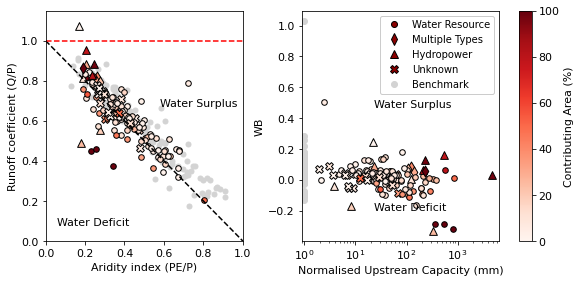

In [8]:
## Produce plot

nat_list = [1] *111
plt.rcParams.update({'font.size': 11})
fig, axs = plt.subplots(nrows=1, ncols=2,  figsize = (9,4))
axs[0].plot([0,1], [1,0], c = 'k', linestyle = 'dashed')
#axs[0].text(-0.1,1.18, 'a)', fontsize = 15)
axs[0].axhline(y=1, linestyle='dashed', color = 'red')
axs[0].scatter(aridity_benchmark, runoff_benchmark, c = 'lightgray', label= 'Benchmark', s = 25)
for i in range(len(runoff_reservoir)):
    scatter =  axs[0].scatter(aridity_reservoir[i], runoff_reservoir[i], edgecolors = 'black', c = res_catchments.iloc[i,7], cmap= 'Reds', marker = marker_list[i], s =marker_size[i])
    scatter.set_clim(0,100)
    axs[0].set_xlim(0,1)
    axs[0].set_ylim(0,1.15)

axs[0].set_xlabel('Aridity index (PE/P)')
axs[0].set_ylabel('Runoff coefficient (Q/P)')
axs[0].text(0.58,0.67, 'Water Surplus', fontsize = 11)
axs[0].text(0.06,0.08, 'Water Deficit', fontsize = 11)
#axs[1].axhline(y=0, linestyle='dashed', color = 'k')
axs[1].set_xlim(0.9,6500)
axs[1].scatter(nat_list,benchmark_catchments['WB'], c = 'lightgray')
for i in range(len(res_catchments)):
    scatter2 = axs[1].scatter(res_catchments.iloc[i,10], reservoir_WB[i], edgecolors = 'black', c = res_catchments.iloc[i,7], cmap= 'Reds', marker = marker_list[i], s =marker_size[i])
    axs[1].set_xscale('log')
    scatter2.set_clim(0,100)
axs[1].set_xlabel('Normalised Upstream Capacity (mm)')
axs[1].text(23,0.47, 'Water Surplus', fontsize = 11)
axs[1].text(23,-0.2, 'Water Deficit', fontsize = 11)
axs[1].set_ylabel('WB')
axs[1].legend(handles=[wr, multiple, hydro, nan, natural], loc='upper right', facecolor = 'white', framealpha = 1, prop={'size': 10})
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.3, hspace=0.02)

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(scatter, cax=cb_ax, label = 'Contributing Area (%)')

**2) Segmentation of the Flow Duration Curve (Seg-FDC)**

Calculate Seg-FDC:

In [9]:
res_Seg_FDC = calc_SegFDC(reservoir_flow_df)
benchmark_Seg_FDC = calc_SegFDC(benchmark_flow_df)

Plot results:

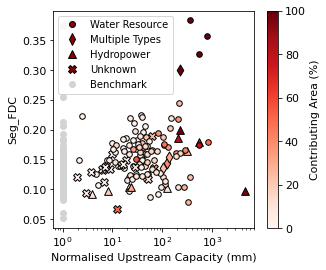

In [10]:
## Produce plot 

plt.rcParams.update({'font.size': 11})
plt.subplots(figsize=(4.5,4))
plt.scatter(nat_list,benchmark_Seg_FDC, c = 'lightgray')
for i in range(len(res_catchments)):
    plt.scatter(res_catchments.iloc[i,10], res_Seg_FDC[i], edgecolors = 'black', c = res_catchments.iloc[i,7], cmap= 'Reds', marker = marker_list[i], s =marker_size[i])
    plt.xscale('log')
    plt.clim(0,100)

plt.xlabel('Normalised Upstream Capacity (mm)')
plt.colorbar( label = 'Contributing Area (%)')
plt.ylabel('Seg_FDC')
plt.legend(handles=[wr, multiple, hydro, nan, natural], prop={'size': 10})

**3) Elasticity (E)**

Calculate E:

In [11]:
res_E, res_annual_precip = calc_E(dates_df, reservoir_flow_df, reservoir_precip_df)
benchmark_E, benchmark_annual_precip = calc_E(dates_df, benchmark_flow_df, benchmark_precip_df)

Plot results:

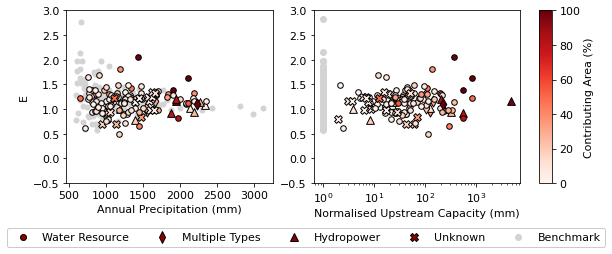

In [13]:
# Produce plot
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 11})
fig, axs = plt.subplots(figsize=(9,4),nrows=1, ncols=2)

axs[0].scatter(benchmark_annual_precip, benchmark_catchments['E'], color = 'lightgrey', label= 'Benchmark', s = 25)
for i in range(len(res_catchments)):
    scatter1 = axs[0].scatter(res_annual_precip[i], res_E[i], edgecolors = 'black', c = res_catchments.iloc[i,7], cmap= 'Reds', marker = marker_list[i], s =marker_size[i])
    scatter1.set_clim(0,100)
    axs[0].set_ylim(-0.5,3)
axs[0].set_xlabel('Annual Precipitation (mm)')
axs[0].set_ylabel('E')

for i in range(len(res_catchments)):
    scatter = axs[1].scatter(res_catchments.iloc[i,10], res_E[i], edgecolors = 'black', c = res_catchments.iloc[i,7], cmap= 'Reds', marker = marker_list[i], s =marker_size[i])
    axs[1].set_xscale('log')
    axs[1].set_ylim(-0.5,3)
    scatter.set_clim(0,100)

axs[1].set_xlabel('Normalised Upstream Capacity (mm)')
axs[1].scatter(nat_list,benchmark_E, c = 'lightgray')

fig.subplots_adjust(bottom=0.2, top=0.8, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.2)

cb_ax = fig.add_axes([0.83, 0.2, 0.02, 0.6])
cbar = fig.colorbar(scatter, cax=cb_ax, label = 'Contributing Area (%)')
ldg = plt.legend(handles=[wr, multiple, hydro, nan, natural], framealpha = 1, facecolor= 'white',ncol = 5, loc = 'lower center',bbox_to_anchor = (-18, -0.40))


**4) Summer / Winter Runoff Ratio (SWRR)**

Calculate SWRR:

In [14]:
res_SWRR, res_runoff_m, res_annual_precip = calc_SWRR(dates_df, reservoir_flow_df, reservoir_precip_df)
benchmark_SWRR, benchmark_runoff_m, benchmark_annual_precip = calc_SWRR(dates_df, benchmark_flow_df, benchmark_precip_df)

Plot results:

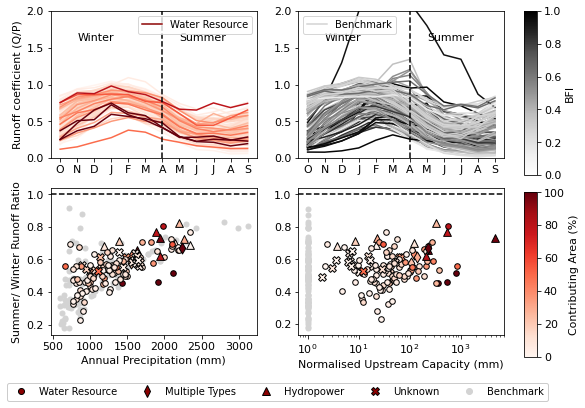

In [16]:
# Produce plot

# Sort dataframe so that catchments with the highest contributing area are plotted on top 
res_catchments_sort = res_catchments.sort_values(by = ['Use', 'Contributing Area (%) '], ascending = [False, True])
res_catchments_sort = res_catchments_sort.reset_index()

# Make plot 

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 11})
fig, axs = plt.subplots(nrows=2, ncols=2,  figsize = (9,6))

for x in range(0,len(benchmark_catchments)):  
    axs[0,1].plot(months_shift, benchmark_runoff_m.iloc[:,x], color= cmap_nat(benchmark_catchments.iloc[x,2]))
sm = plt.cm.ScalarMappable(cmap=cmap_nat)
sm.set_clim(0, 1)
axs[0,1].plot(months_shift,benchmark_runoff_m.iloc[:,x], label = 'Benchmark', color='lightgray')
axs[0,1].set_xticklabels(months_shift_letters, fontsize=11)
axs[0,1].set_ylim([0,2])
axs[0,1].legend(prop={'size': 10})
axs[0,1].axvline(x=6, linestyle='dashed', color = 'black')
axs[0,1].text('Nov',1.6, 'Winter', fontsize = 11)
axs[0,1].text('May',1.6, 'Summer', fontsize = 11)
for i in res_catchments_sort[res_catchments_sort.Use == 'WR'].iloc[:,0]:
    axs[0,0].plot(months_shift, res_runoff_m.iloc[:,i], color= cmap_WR(res_catchments.iloc[i,7]/100))
sm = plt.cm.ScalarMappable(cmap=cmap_WR)
sm.set_clim(0, 100)
axs[0,0].legend(handles = [wr_line], prop={'size': 10})
axs[0,0].set_xticklabels(months_shift_letters, fontsize=11)
axs[0,0].set_ylim([0,2])
axs[0,0].set_ylabel('Runoff coefficient (Q/P)')
axs[0,0].axvline(x=6, linestyle='dashed', color = 'black')
axs[0,0].text('Nov',1.6, 'Winter', fontsize = 11)
axs[0,0].text('May',1.6, 'Summer', fontsize = 11)


axs[1,0].scatter(benchmark_annual_precip, benchmark_SWRR,  color = 'lightgrey', label= 'Benchmark', s = 25)
for i in range(len(res_catchments)):
    scatter =  axs[1,0].scatter(res_annual_precip[i], res_SWRR[i], edgecolors = 'black', c = res_catchments.iloc[i,7], cmap= 'Reds', marker = marker_list[i], s =marker_size[i])
    scatter.set_clim(0,100)
axs[1,0].set_xlabel('Annual Precipitation (mm)')
axs[1,0].set_ylabel('Summer/ Winter Runoff Ratio')
axs[1,0].axhline(y=1, linestyle='dashed', color = 'black')

for i in range(len(res_catchments)):
    scatter2 = axs[1,1].scatter(res_catchments.iloc[i,10], res_SWRR[i], edgecolors = 'black', c = res_catchments.iloc[i,7], cmap= 'Reds', marker = marker_list[i], s =marker_size[i])
    axs[1,1].set_xscale('log')
    scatter2.set_clim(0,100)
axs[1,1].set_xlabel('Normalised Upstream Capacity (mm)')
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.02)
axs[1,1].axhline(y=1, linestyle='dashed', color = 'black')
axs[1,1].scatter(nat_list,benchmark_catchments['SWRR'], c = 'lightgray', s = 25)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.38])
cbar = fig.colorbar(scatter, cax=cb_ax, label = 'Contributing Area (%)')
ldg = plt.legend(handles=[wr, multiple, hydro, nan, natural], framealpha = 1, facecolor= 'white',ncol = 5, loc = 'lower center',bbox_to_anchor = (-19, -0.3), prop={'size': 10})
cb_ax2 = fig.add_axes([0.83, 0.52, 0.02, 0.38])
cbar2 = fig.colorbar(plt.cm.ScalarMappable( cmap=cmap_nat), cax=cb_ax2, label = 'BFI')
fig.subplots_adjust(bottom=0.15, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.2)

**5) Low Flow Variability (LFV)**

Calculate LFV:

In [17]:
res_LFV, res_q80_m = calc_LFV(reservoir_flow_df, dates_df)
benchmark_LFV, benchmark_q80_m = calc_LFV(benchmark_flow_df, dates_df)

Plot results:

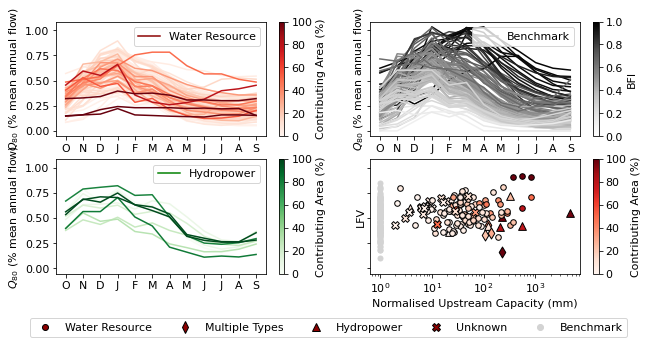

In [18]:
# Produce plot 
plt.rcParams.update({'font.size': 11})
fig, axs = plt.subplots(nrows=2, ncols=2,  figsize = (10,5), sharey= True)

for x in range(0,len(benchmark_catchments)):  
    axs[0,1].plot(months_shift, benchmark_q80_m.iloc[:,x], c = cmap_nat(benchmark_catchments.iloc[x, 2]))
sm = plt.cm.ScalarMappable(cmap=cmap_nat)
fig.colorbar(sm, ax = axs[0,1], label = 'BFI')
sm.set_clim(0, 1)
axs[0,1].plot(months_shift,benchmark_q80_m.iloc[:,x], label = 'Benchmark', color='lightgray')

axs[0,1].legend()
axs[0,1].set_ylabel('$Q_{80}$ (% mean annual flow)')
axs[0,1].set_xticklabels(months_shift_letters, fontsize=11)

for i in res_catchments_sort[res_catchments_sort.Use == 'WR'].iloc[:,0]:
    axs[0,0].plot(months_shift, res_q80_m.iloc[:,i], color= cmap_WR((res_catchments.iloc[i,7]/100)))

sm = plt.cm.ScalarMappable(cmap=cmap_WR)
fig.colorbar(sm, ax = axs[0,0], label = 'Contributing Area (%)')

sm.set_clim(0, 100)
axs[0,0].legend(handles = [wr_line])

axs[0,0].set_ylabel('$Q_{80}$ (% mean annual flow)')
axs[0,0].set_xticklabels(months_shift_letters, fontsize=11)
for i in res_catchments_sort[res_catchments_sort.Use == 'H'].iloc[:,0]:
    axs[1,0].plot(months_shift, res_q80_m.iloc[:,i], color= cmap_H((res_catchments.iloc[i,7]/100)))

sm = plt.cm.ScalarMappable(cmap=cmap_H)
fig.colorbar(sm, ax = axs[1,0], label = 'Contributing Area (%)')
sm.set_clim(0, 100)
axs[1,0].legend(handles = [hydro_line])

axs[1,0].set_ylabel('$Q_{80}$ (% mean annual flow)')
axs[1,0].set_xticklabels(months_shift_letters, fontsize=11)

for i in range(len(res_catchments)):
    scatter = axs[1,1].scatter(res_catchments.iloc[i,10], res_LFV[i], edgecolors = 'black',color= cmap_WR((res_catchments.iloc[i,7]/100)), cmap= 'Reds', marker = marker_list[i], s =marker_size[i])
    axs[1,1].set_xscale('log')
    scatter.set_clim(0, 100)
sm = plt.cm.ScalarMappable(cmap=cmap_WR)
sm.set_clim(0, 100)
fig.colorbar(sm, ax = axs[1,1], label = 'Contributing Area (%)')
axs[1,1].set_xlabel('Normalised Upstream Capacity (mm)')
axs[1,1].set_ylabel('LFV')
ldg = axs[1,1].legend(handles=[wr, multiple, hydro, nan, natural],ncol = 5, loc = 'lower center',bbox_to_anchor = (-0.2, -0.6))
axs[1,1].scatter(nat_list,benchmark_LFV, c = 'lightgray', s= 25)
fig.subplots_adjust(bottom=0.25, top=0.95, left=0.1, right=0.9,
                    wspace=0.2, hspace=0.2)